In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


In [3]:
import os
import pandas as pd
def load_housing_data():
    
    return pd.read_csv("housing.csv")



housing = load_housing_data()

In [4]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)


# 根据收入类别进行分层抽样了。使用Scikit-Learn的
# Stratified-Shuffle Split类

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set


# print(housing)
housing_labels = strat_train_set["median_house_value"].copy()

In [5]:
print(type(housing_labels))

<class 'pandas.core.series.Series'>


In [6]:
print(housing_labels.shape)

(16512,)


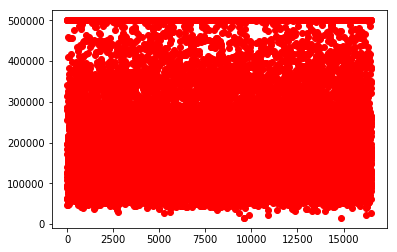

In [7]:
x1=np.arange(0,len(housing_labels))
# plt.plot(x1,housing_labels,marker='*')
plt.scatter(x1,housing_labels,color='red')
plt.show()


In [8]:
from sklearn.base import BaseEstimator, TransformerMixin


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6


# 类的功能是为原数据集添加新的特征，X[:,3]表示的是第4列所有数据，np.c_表示的是拼接数组。
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):

    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]



In [9]:
from sklearn.base import TransformerMixin #gives fit_transform method for free
from sklearn.preprocessing import LabelBinarizer


class MyLabelBinarizer(TransformerMixin):

    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)

    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self

    def transform(self, x, y=0):
        return self.encoder.transform(x)

In [10]:
from sklearn.preprocessing import Imputer, StandardScaler, LabelBinarizer
from sklearn.pipeline import FeatureUnion, Pipeline



housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
# print(num_attribs)
cat_attribs = ["ocean_proximity"]


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])


cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer',MyLabelBinarizer()),
])


full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

# print(housing)
housing_prepared = full_pipeline.fit_transform(housing)
# print(housing_prepared)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

68628.1981985


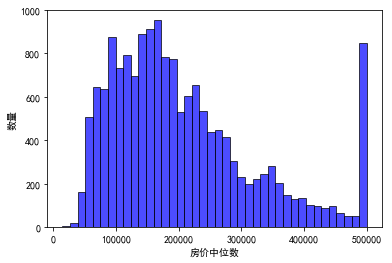

In [30]:
plt.hist(housing_labels, bins=40, normed=0, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("房价中位数")
# 显示纵轴标签
plt.ylabel("数量")
plt.show()

大多数地区的median_housing_values分布在120000到265000美元之间，所以典型的预测误差达到68628美元只能算是差强人意。

下面这里是拿几个小数据量进行尝试

In [21]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
Predictions=lin_reg.predict(some_data_prepared)


In [22]:
def show_res(y_test,y_predict):
    '''
    结果展示
    :param y_test: 测试集目标值真实值
    :param y_predict: 预测值
    :return:
    '''
    plt.rcParams['font.sans-serif'] = 'SimHei'
    plt.rcParams['axes.unicode_minus'] = False
 
    plt.figure()
    x = np.arange(0,len(y_predict))
 
    plt.plot(x,y_test,marker='*')
    plt.plot(x,y_predict,marker='o')
 
 
    plt.title('房价预测与真实值的走势')
    plt.xlabel('x轴')
    plt.ylabel('房价')
 
    plt.legend(['真实值','预测值'])
    plt.show()


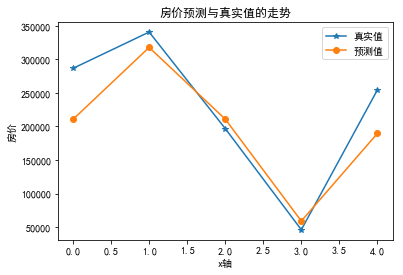

In [23]:
show_res(some_labels,Predictions)

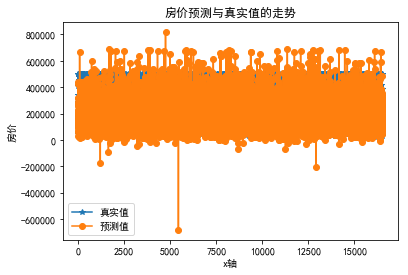

In [15]:
show_res(housing_labels,housing_predictions)